In [1]:
# !pip install sklearn pandas matplotlib

In [70]:
import pandas as pd
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from utilities import *
import seaborn as sns
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## global vars

In [71]:
TEST_SIZE=0.2

## read the training data


In [72]:
data = pd.read_csv("train/train.csv").dropna()
print("number of features is ", data.shape)
data.head()

number of features is  (7903, 40)


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4521252780,1,11,2,0,5,5,1,0,0,...,0,15521,6.8,18175,222,48,-544,-2063,22.2,1552.1
1,4516789805,1,17,2,0,9,4,8,1,0,...,0,15946,6.6,17106,230,52,-3538,-2904,23.0,1594.6
2,4517546735,1,85,6,1,9,1,11,1,1,...,0,13584,7.0,17661,217,42,-5240,-2335,21.7,1358.4
3,4508668617,0,17,3,0,6,4,8,0,0,...,0,15036,6.8,17006,225,40,-1954,-1045,22.5,1503.6
4,4462493939,0,16,2,0,8,9,8,0,0,...,0,18704,7.2,19776,226,52,1720,1376,22.6,1870.4


In [73]:
X,y = separate_feature_label(data, "blueWins")

In [74]:
X.shape

(7903, 39)

## preprocessing and analysis

### get the attributes with low correlation only


<AxesSubplot:>

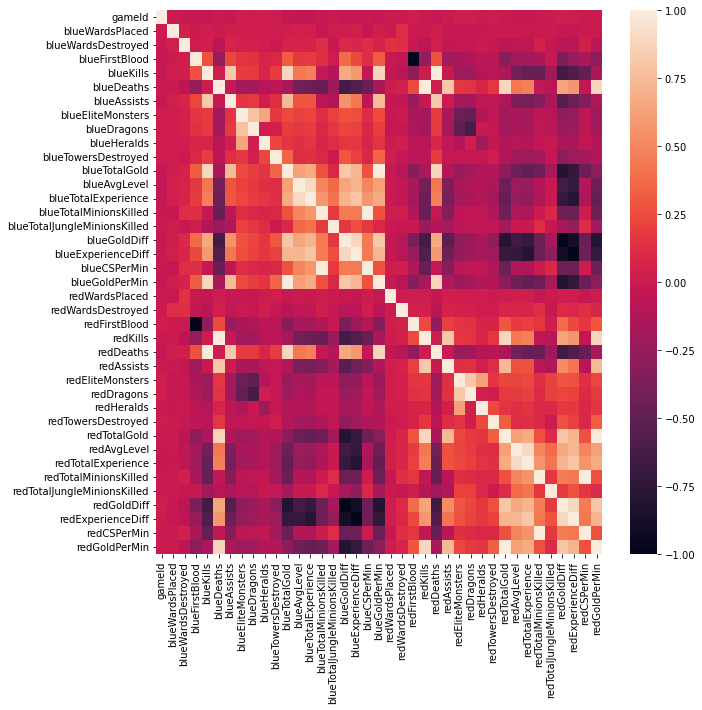

In [75]:
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr())

In [8]:
corrTable = X.corr()
cols = X.columns

In [9]:
newCols = []
for i in cols:
    for j in cols:
        if( i!=j and abs(corrTable[i][j])<0.01 ):
            newCols.append(j)
newCols = list( pd.Series(newCols).unique() )
print( len(newCols) )
X = X[newCols]

29


In [10]:
len(cols) , len(newCols)
diff_col = [col for col in cols if col not in newCols]
diff_col

['blueKills',
 'blueTotalGold',
 'blueGoldDiff',
 'blueExperienceDiff',
 'blueGoldPerMin',
 'redDeaths',
 'redEliteMonsters',
 'redDragons',
 'redGoldDiff',
 'redExperienceDiff']

## remove the outliers


In [11]:
len(newCols)

29

In [12]:
X.describe()

,blueWardsPlaced,blueDeaths,blueDragons,blueTowersDestroyed,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueCSPerMin,redWardsPlaced,redWardsDestroyed,redKills,...,redFirstBlood,redTowersDestroyed,redAvgLevel,blueWardsDestroyed,redTotalExperience,blueHeralds,blueAvgLevel,blueTotalExperience,blueEliteMonsters,blueAssists
count,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,...,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000
mean,22.153992,6.127547,0.360369,0.050867,216.710616,50.521448,21.671062,22.477667,2.720486,6.127547,...,0.494749,0.042262,6.925117,2.830824,17957.448943,0.185879,6.913830,17922.391623,0.546248,6.652410
std,17.720187,2.931458,0.480138,0.241156,21.675143,9.850413,2.167514,18.509076,2.104507,2.931458,...,0.500004,0.214592,0.303919,2.196290,1193.670605,0.389033,0.302625,1187.832554,0.626429,4.060479
min,8.000000,0.000000,0.000000,0.000000,90.000000,0.000000,9.000000,6.000000,0.000000,0.000000,...,0.000000,0.000000,4.800000,0.000000,10465.000000,0.000000,4.800000,10826.000000,0.000000,0.000000
25%,14.000000,4.000000,0.000000,0.000000,203.000000,44.000000,20.300000,14.000000,1.000000,4.000000,...,0.000000,0.000000,6.800000,1.000000,17206.000000,0.000000,6.800000,17169.000000,0.000000,4.000000
50%,16.000000,6.000000,0.000000,0.000000,218.000000,50.000000,21.800000,16.000000,2.000000,6.000000,...,0.000000,0.000000,7.000000,3.000000,17958.000000,0.000000,7.000000,17944.000000,0.000000,6.000000
75%,20.000000,8.000000,1.000000,0.000000,232.000000,56.000000,23.200000,20.000000,4.000000,8.000000,...,1.000000,0.000000,7.200000,4.000000,18760.000000,0.000000,7.200000,18713.000000,1.000000,9.000000
max,250.000000,19.000000,1.000000,4.000000,283.000000,85.000000,28.300000,276.000000,24.000000,19.000000,...,1.000000,2.000000,8.200000,27.000000,22269.000000,1.000000,8.000000,22224.000000,2.000000,29.000000


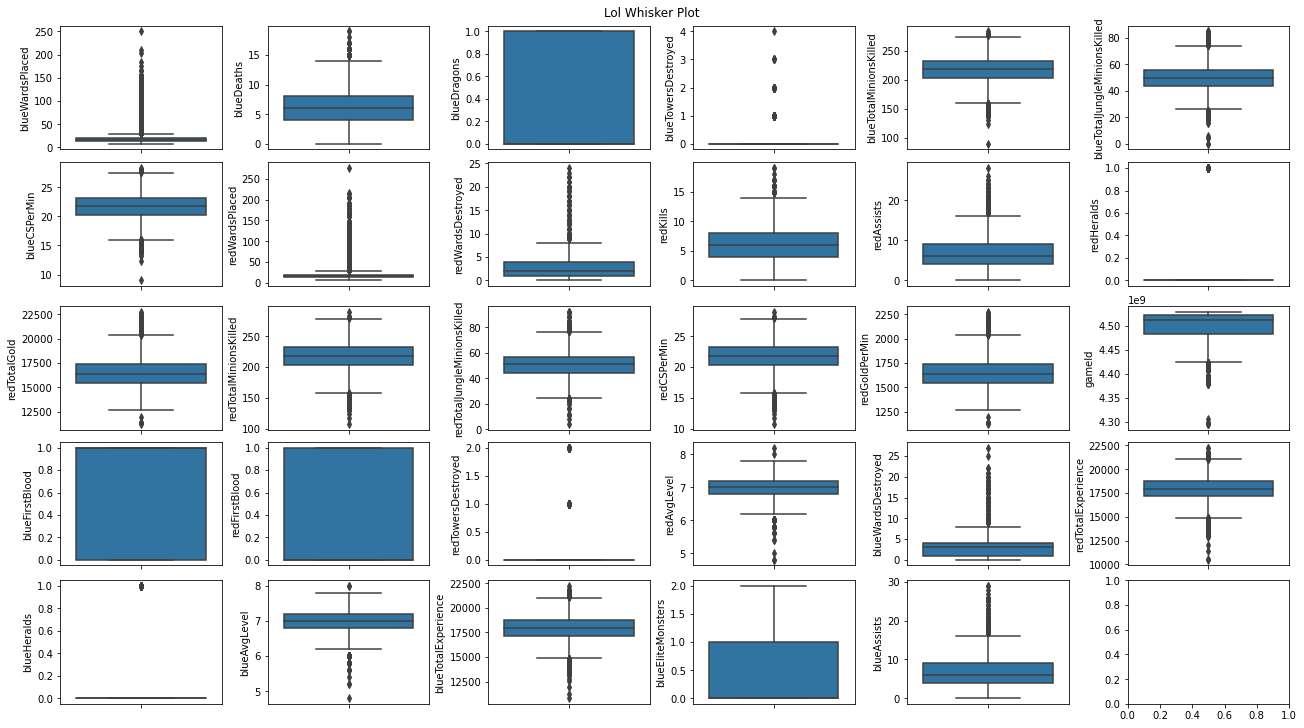

In [13]:
def whisker(data, title, colNames):

    fig, axes = plt.subplots(5, 6, figsize=(18, 10),constrained_layout=True)

    fig.suptitle(title)
    for i, col in enumerate(colNames):
        sns.boxplot(ax=axes[i//6, i - (i//6)*6], data=data, y=colNames[i])

whisker(X, 'Lol Whisker Plot', newCols)
    


In [14]:
print(newCols)

['blueWardsPlaced', 'blueDeaths', 'blueDragons', 'blueTowersDestroyed', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueCSPerMin', 'redWardsPlaced', 'redWardsDestroyed', 'redKills', 'redAssists', 'redHeralds', 'redTotalGold', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redCSPerMin', 'redGoldPerMin', 'gameId', 'blueFirstBlood', 'redFirstBlood', 'redTowersDestroyed', 'redAvgLevel', 'blueWardsDestroyed', 'redTotalExperience', 'blueHeralds', 'blueAvgLevel', 'blueTotalExperience', 'blueEliteMonsters', 'blueAssists']


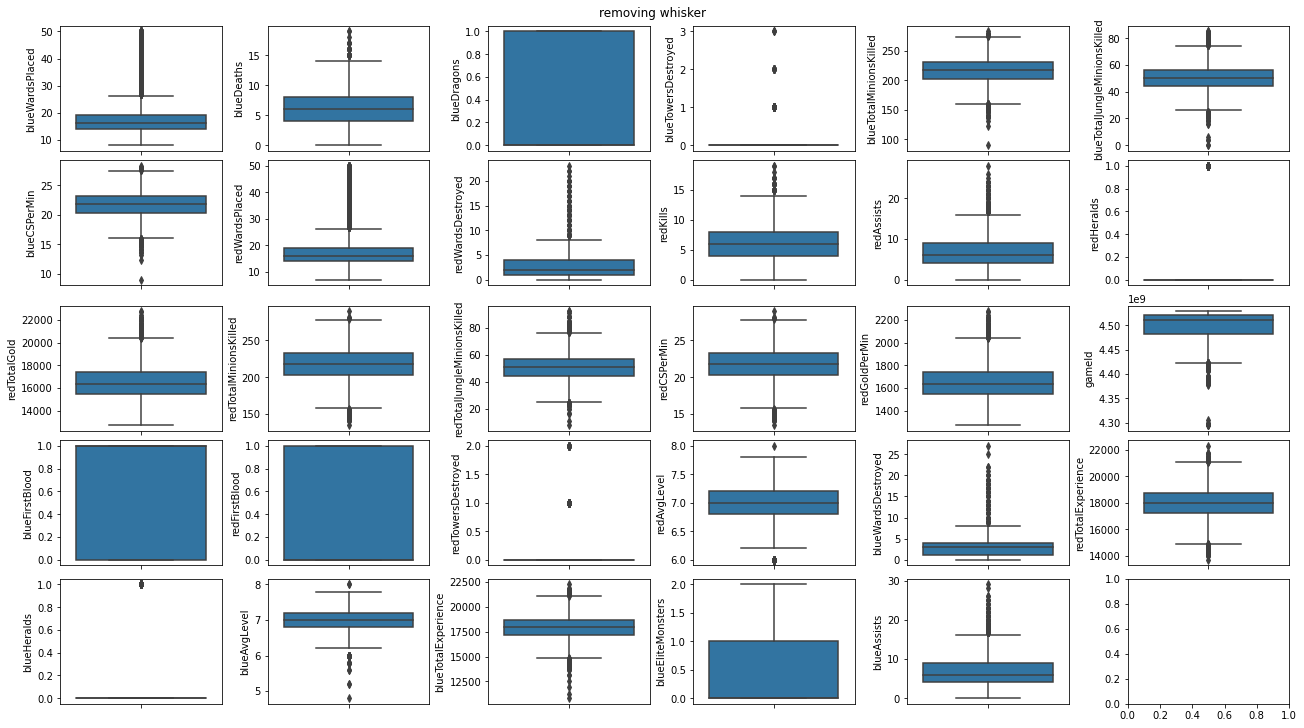

In [15]:
removable_ouliers = [
    {
        'min':0,
        'max':50,
        'col':'blueWardsPlaced'
    },
    {
        'min':0,
        'max':50,
        'col':'redWardsPlaced'
    },{

        'min':6,
        'max':8,
        'col':'redAvgLevel'
        
    }
]


for to_remove_outlier in removable_ouliers:
    # print(X[X[to_remove_outlier['col']] > to_remove_outlier['max'] ])
    # print(to_remove_outlier)
    # break
    data = data[data[to_remove_outlier['col']] <= to_remove_outlier['max'] ]
    data = data[data[to_remove_outlier['col']] >= to_remove_outlier['min'] ]
    
X,y = separate_feature_label(data, "blueWins")
X = X[newCols]

whisker(X, "removing whisker" , newCols)


### inital model


In [78]:

treeClassifier = tree.DecisionTreeClassifier(
    min_samples_leaf=100, max_depth=10
)
X_train, X_test, y_train, y_test =train_test_split( X, y, test_size=TEST_SIZE, random_state=42)


### parameter tuning and validation


In [43]:
parameters = {'max_depth':[10,11,12,20], 
              'min_samples_leaf':[50,100,150], 
              'min_samples_split':[10,50,100,150,200,250],
              'criterion' : ['gini','entropy']}
scorer = make_scorer(f1_score)

search_obj = RandomizedSearchCV(treeClassifier, parameters, scoring=scorer)
fit_obj = search_obj.fit(X_train, y_train)
best_clf = fit_obj.best_estimator_

print( "Accuracy for tree classifier: "+str( metrics.accuracy_score(y_test, best_clf.predict(X_test)) ) )


Accuracy for tree classifier: 0.6933198380566802


In [44]:
print("best parameters is ", fit_obj.best_params_)


best parameters is  {'min_samples_split': 150, 'min_samples_leaf': 100, 'max_depth': 20, 'criterion': 'entropy'}


In [19]:
test_this_model(best_clf, newCols)

Accuracy for tree classifier: 0.6923076923076923


## final classifier

In [20]:
treeClassifier = best_clf

[Text(0.4650974025974026, 0.95, 'redTotalGold <= 15958.0\ngini = 0.5\nsamples = 5601\nvalue = [2803, 2798]\nclass = lose'),
 Text(0.2159090909090909, 0.85, 'redTotalExperience <= 17301.5\ngini = 0.405\nsamples = 2156\nvalue = [608, 1548]\nclass = win'),
 Text(0.08116883116883117, 0.75, 'blueTotalExperience <= 17835.5\ngini = 0.308\nsamples = 1121\nvalue = [213, 908]\nclass = win'),
 Text(0.025974025974025976, 0.65, 'blueFirstBlood <= 0.5\ngini = 0.452\nsamples = 304\nvalue = [105, 199]\nclass = win'),
 Text(0.012987012987012988, 0.55, 'gini = 0.5\nsamples = 111\nvalue = [55, 56]\nclass = win'),
 Text(0.03896103896103896, 0.55, 'redTotalGold <= 15274.5\ngini = 0.384\nsamples = 193\nvalue = [50, 143]\nclass = win'),
 Text(0.025974025974025976, 0.45, 'gini = 0.318\nsamples = 126\nvalue = [25, 101]\nclass = win'),
 Text(0.05194805194805195, 0.45, 'gini = 0.468\nsamples = 67\nvalue = [25, 42]\nclass = win'),
 Text(0.13636363636363635, 0.65, 'redTotalExperience <= 16564.5\ngini = 0.229\nsamp

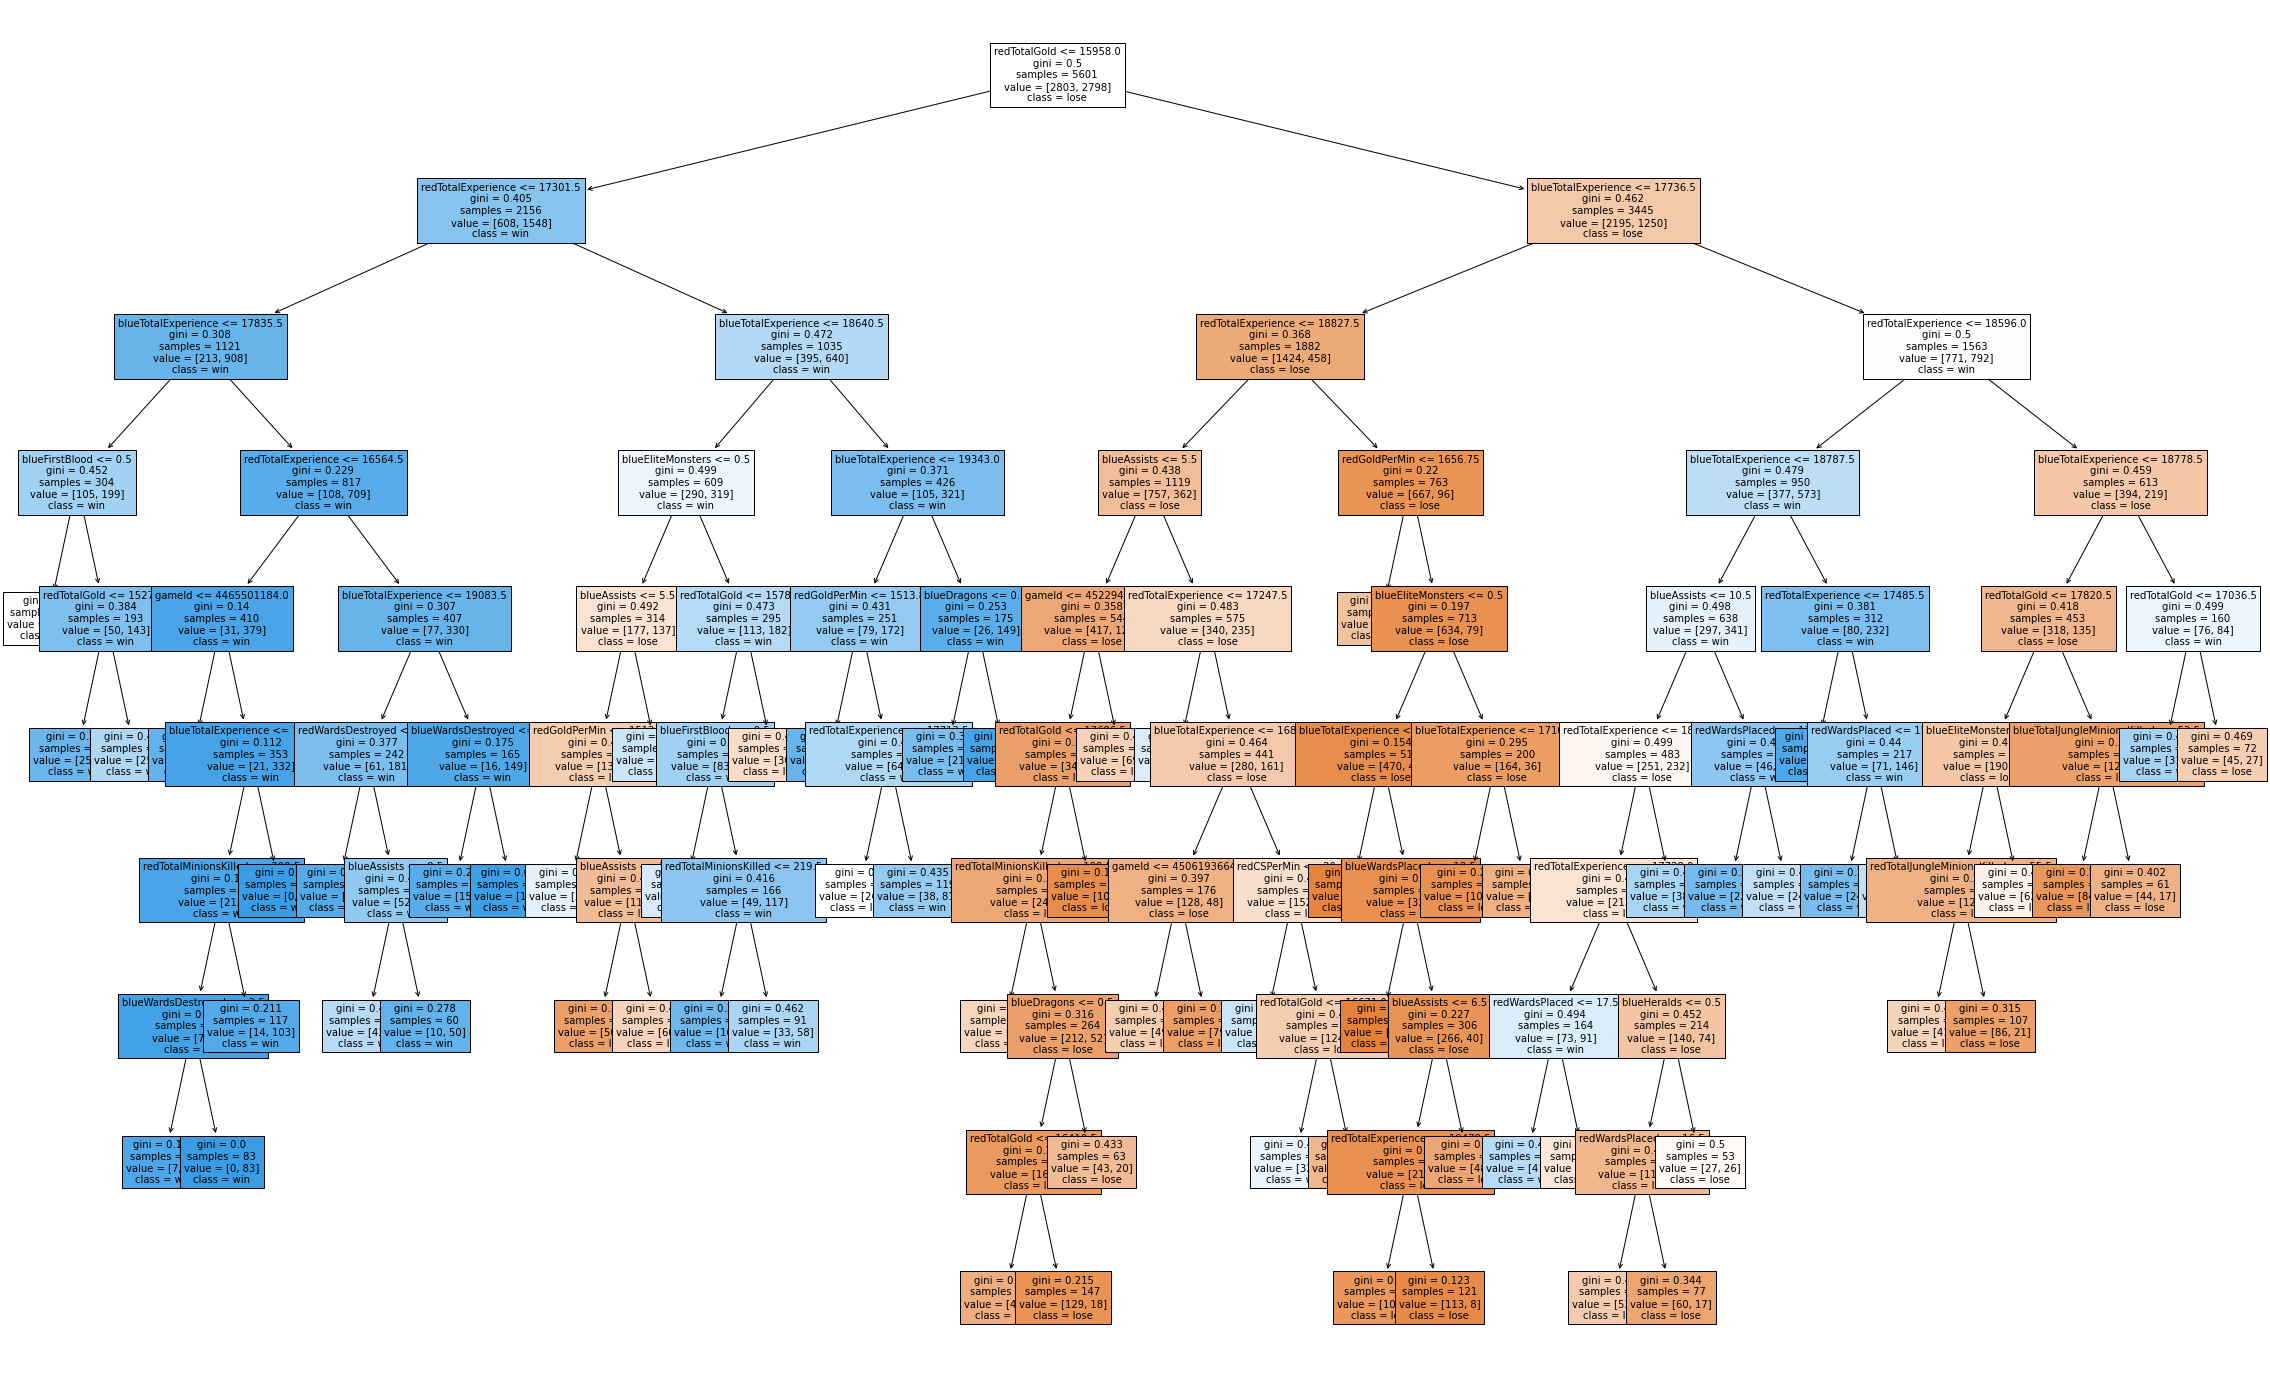

In [67]:
fig = plt.figure(figsize=(40,25))

tree.plot_tree(treeClassifier, class_names=["lose", "win"],feature_names=newCols,filled=True,fontsize=10)


## DecisionTree model testing on unseen data

In [22]:

test_data = pd.read_csv("test/test.csv").dropna()


X_test,y_test = separate_feature_label(test_data, "blueWins")
X_test = X_test[newCols]

print( "Accuracy for tree classifier: "+str( metrics.accuracy_score(y_test, treeClassifier.predict(X_test)) ) )


Accuracy for tree classifier: 0.6923076923076923


# Logistic Regression

In [23]:
from sklearn.metrics import accuracy_score
# fit logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## building the model

In [24]:

scaler = MinMaxScaler()
X_reg = X[newCols]
y_reg = y
scaler.fit(X_reg)
X_reg = scaler.transform(X_reg)

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=TEST_SIZE, random_state=42)

In [25]:

logisticRegressor = LogisticRegression()
logisticRegressor.fit(X_train, y_train)


# get accuracy score
pred_lm = logisticRegressor.predict(X_test)
acc_lm = accuracy_score(pred_lm, y_test)
print(acc_lm)

0.7330478229835832


/home/mohammed/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## LogisticRegression model testing on unseen data

In [26]:

test_data = pd.read_csv("test/test.csv").dropna()


X_test,y_test = separate_feature_label(test_data, "blueWins")
X_test = X_test[newCols]
X_test = scaler.transform(X_test)

print( "Accuracy for LogisticRegression classifier: "+str( metrics.accuracy_score(y_test, logisticRegressor.predict(X_test)) ) )


Accuracy for LogisticRegression classifier: 0.7327935222672065


# Adaboost Classifier

In [27]:
from sklearn.ensemble import AdaBoostClassifier

## Model tuning

In [28]:
print(len(newCols))

29


In [29]:
ababooster = AdaBoostClassifier(n_estimators=100, random_state=42)

ababooster.fit(X_train, y_train)

# get accuracy score
pred_lm = ababooster.predict(X_test)
acc_lm = accuracy_score(pred_lm, y_test)
print(acc_lm)

0.7211538461538461


In [30]:
ababooster = AdaBoostClassifier(n_estimators=100, random_state=42)

parameters = {
        'n_estimators':[90,100,150],
        'base_estimator':[tree.DecisionTreeClassifier( max_depth=1),tree.DecisionTreeClassifier( max_depth=2)]
            }
scorer = make_scorer(f1_score)

search_obj = RandomizedSearchCV(ababooster, parameters, scoring=scorer)
fit_obj = search_obj.fit(X_train, y_train)
best_clf = fit_obj.best_estimator_

print( "Accuracy for tree classifier: "+str( metrics.accuracy_score(y_test, best_clf.predict(X_test)) ) )


/home/mohammed/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy for tree classifier: 0.7211538461538461


In [41]:
print("best parameters is ", fit_obj.best_params_)


best parameters is  {'n_estimators': 100, 'base_estimator': DecisionTreeClassifier(max_depth=1)}


In [32]:
ababooster=best_clf

In [76]:

test_data = pd.read_csv("test/test.csv").dropna()


X_test,y_test = separate_feature_label(test_data, "blueWins")
X_test = X_test[newCols]
X_test = scaler.transform(X_test)

print( "Accuracy for tree classifier: "+str( metrics.accuracy_score(y_test, ababooster.predict(X_test)) ) )


Accuracy for tree classifier: 0.7211538461538461


# SVM 

## Model Training and Tuning

In [77]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svmer = svm.SVC(kernel='linear') # Linear Kernel

parameters = {
        'kernel':["linear","poly"],
        "C":[2.0, 1.0 , .75 ,.5, .25 , .01, .001]
            }
scorer = make_scorer(f1_score)

search_obj = RandomizedSearchCV(svmer, parameters, scoring=scorer)
fit_obj = search_obj.fit(X_train, y_train)
best_clf = fit_obj.best_estimator_

#Train the model using the training sets
svmer.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = svmer.predict(X_test)



In [ ]:
pred_lm = y_pred.predict(X_test)
acc_lm = accuracy_score(pred_lm, y_test)
print(acc_lm)

In [56]:
print("best parameters is ", fit_obj.best_params_)


best parameters is  {'kernel': 'linear', 'C': 0.75}


## Model Testing

In [57]:
#Import scikit-learn metrics module for accuracy calculation

test_data = pd.read_csv("test/test.csv").dropna()


X_test,y_test = separate_feature_label(test_data, "blueWins")
X_test = X_test[newCols]
X_test = scaler.transform(X_test)

print( "Accuracy for tree classifier: "+str( metrics.accuracy_score(y_test, svmer.predict(X_test)) ) )



Accuracy for tree classifier: 0.7267206477732794
